In [710]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from scipy.spatial.distance import pdist
import torch.optim as optim

from matplotlib.lines import Line2D  # Import Line2D for custom legend

from torch.optim.lr_scheduler import ReduceLROnPlateau


from utils import *

We moved all the useful functions from the previous assignments to a separate file utils.py. You can simply import them with the following line. Feel free to add additional functions or modify the existing ones!

In [711]:
from utils import MLP, split_data, Dataset, train

In [712]:
# check if a GPU is available
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cpu'

In [713]:
molecule = np.array(
    [
        [0.702581, 1.820873],
        [0.702581, 0.296325],
        [-0.702581, -0.296325],
        [-0.702581, -1.820873],
    ]
)

n_atoms = molecule.shape[0]
n_dimensions = molecule.shape[1]

print(
    f"Number of particles: {n_atoms} \nNumber of spatial dimensions: {n_dimensions}",
)

Number of particles: 4 
Number of spatial dimensions: 2


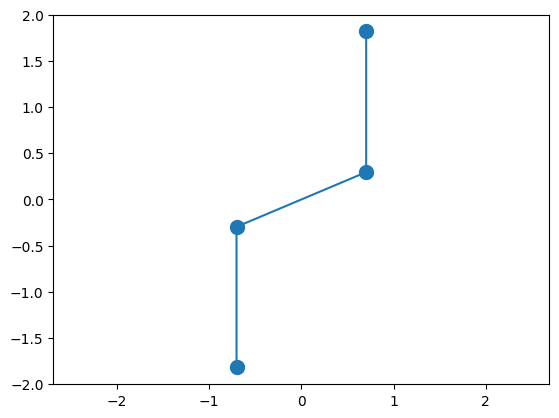

In [714]:
plt.plot(molecule[:, 0], molecule[:, 1], "o-", markersize=10)
plt.axis("equal")

plt.show()

In [715]:
n_samples = 5000
mean = 0
standard_dev = 0.1
noise = np.random.normal(
                 size=(n_samples, n_atoms, n_dimensions),
                 loc=mean, 
                 scale = standard_dev,
)

noised_molecules = noise + molecule
noised_molecules

array([[[ 0.71577991,  1.87033822],
        [ 0.79742457,  0.31049574],
        [-0.67376479, -0.33136287],
        [-0.66991145, -1.75904272]],

       [[ 0.74458338,  1.9202048 ],
        [ 0.72944033,  0.19580944],
        [-0.70052152, -0.39963079],
        [-0.54068808, -1.85899277]],

       [[ 0.59436448,  2.01417809],
        [ 0.68359887,  0.25793464],
        [-0.75075599, -0.37379527],
        [-0.60000114, -1.85029109]],

       ...,

       [[ 0.79291593,  1.73665997],
        [ 0.76410832,  0.34226825],
        [-0.57539783, -0.41402749],
        [-0.5683191 , -1.74531916]],

       [[ 0.85866731,  1.66763952],
        [ 0.62941368,  0.45807478],
        [-0.72839416, -0.3361426 ],
        [-0.82177221, -1.65646651]],

       [[ 0.91635063,  1.76959708],
        [ 0.78794346,  0.30100136],
        [-0.60373775, -0.29528117],
        [-0.75926152, -1.74774068]]])

In [716]:
def plot_mollies(mollies, title="Molecules with Noise"):
  labeled = False
  alpha = 50 / n_samples
  for mol in mollies:
    mol = np.array(mol)
    if not labeled:
      plt.plot(mol[:, 0], mol[:, 1], "o-", markersize=10, c="Blue", alpha=alpha, 
              label=f"Probability cloud of molecule with: \n\t{n_samples} samples, \n\tmean: {mean}, \n\tstandard deviation: {standard_dev}")
      labeled = True
    else:
      plt.plot(mol[:, 0], mol[:, 1], "o-", markersize=10, c="Blue", alpha=alpha)

  legend_handle = Line2D([0], [0], marker='o', color='blue', markerfacecolor='blue', markersize=10, alpha=.5)  # Higher alpha for legend

  plt.axis("equal")
  plt.xlabel("X")
  plt.ylabel("Y")
  plt.title("Molecule with Noise")

  plt.legend([legend_handle], [f"Probability cloud of molecule with \n{n_samples} samples, \nmean: {mean}, \nstandard deviation: {standard_dev}"])


  plt.tight_layout()
  plt.show()

# def plot_dataset(my_dataset, title="Molecules with Noise"):
#     # mollies = [my_dataset[i][0].tolist() for i in range(len(my_dataset)) ]
#     # alpha = 50 / n_samples
#     print(mollies)
#     plot_mollies(mollies, title)



In [717]:
noised_molecules

array([[[ 0.71577991,  1.87033822],
        [ 0.79742457,  0.31049574],
        [-0.67376479, -0.33136287],
        [-0.66991145, -1.75904272]],

       [[ 0.74458338,  1.9202048 ],
        [ 0.72944033,  0.19580944],
        [-0.70052152, -0.39963079],
        [-0.54068808, -1.85899277]],

       [[ 0.59436448,  2.01417809],
        [ 0.68359887,  0.25793464],
        [-0.75075599, -0.37379527],
        [-0.60000114, -1.85029109]],

       ...,

       [[ 0.79291593,  1.73665997],
        [ 0.76410832,  0.34226825],
        [-0.57539783, -0.41402749],
        [-0.5683191 , -1.74531916]],

       [[ 0.85866731,  1.66763952],
        [ 0.62941368,  0.45807478],
        [-0.72839416, -0.3361426 ],
        [-0.82177221, -1.65646651]],

       [[ 0.91635063,  1.76959708],
        [ 0.78794346,  0.30100136],
        [-0.60373775, -0.29528117],
        [-0.75926152, -1.74774068]]])

/var/folders/y9/lzm82l3943n1ly680x98vpm40000gn/T/ipykernel_75846/1935090512.py:23: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


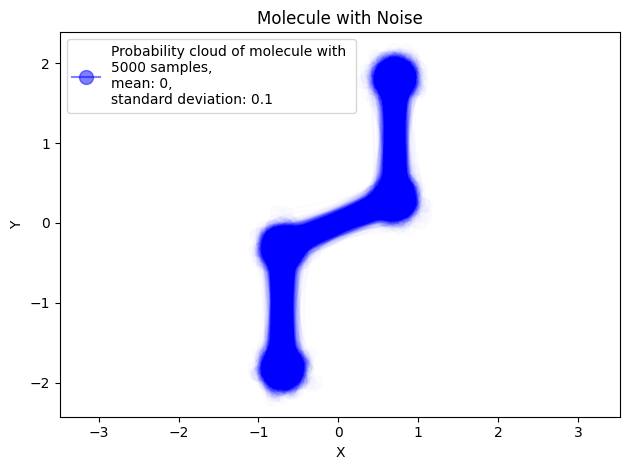

In [718]:
plot_mollies(noised_molecules)

## 1.2 Featurization

Here's an example of how to use pdist:

In [719]:
distances = pdist(molecule)
distances2 = [np.array([np.linalg.norm(mol[i] - mol[j]) for i in range(n_atoms) for j in range(i + 1, n_atoms)]) for mol in noised_molecules]
distances

array([1.524548  , 2.54106427, 3.90343364, 1.52502927, 2.54106427,
       1.524548  ])

We can check that these distances are correct:

In [720]:
# Distance atom 0 - 1
print(f"{np.linalg.norm(molecule[0,:] - molecule[1,:]):.6f}")
# Distance atom 0 - 2
print(f"{np.linalg.norm(molecule[0,:] - molecule[2,:]):.6f}")
# Distance atom 0 - 3
print(f"{np.linalg.norm(molecule[0,:] - molecule[3,:]):.6f}")
# Distance atom 1 - 2
print(f"{np.linalg.norm(molecule[1,:] - molecule[2,:]):.6f}")
# Distance atom 1 - 3
print(f"{np.linalg.norm(molecule[1,:] - molecule[3,:]):.6f}")
# Distance atom 2 - 3
print(f"{np.linalg.norm(molecule[2,:] - molecule[3,:]):.6f}")


1.524548
2.541064
3.903434
1.525029
2.541064
1.524548


In [721]:
flattened_coordinates = [np.reshape(mol, (n_atoms*n_dimensions)) for mol in noised_molecules]
distances = [pdist(mol) for mol in noised_molecules]
potentials = [(1 / dist) for dist in distances]
total_energies = [sum(potential) for potential in potentials]
# potentials
# distances
total_energies

[2.9993354740863065,
 2.936996429211094,
 2.8977136666715486,
 2.7250319375215026,
 3.081955830989859,
 3.019634291454085,
 3.32801828307055,
 3.1322099975501203,
 3.0572620888051385,
 3.2497311752976614,
 2.942599704235192,
 3.3257024300075857,
 3.05917084612806,
 2.998367063215117,
 3.0166569729731054,
 3.097186305699643,
 3.007131098030949,
 2.869582303946048,
 2.9131876533350196,
 2.973195683293389,
 2.885614388755502,
 3.072950790048993,
 3.0619564273869884,
 3.010826399552321,
 3.0652900957885008,
 3.0671691388082287,
 2.9873486778364393,
 2.916817976871589,
 2.8098884683074177,
 3.0566796380131667,
 3.0204199862931196,
 3.149116051974456,
 3.0444614596669686,
 3.067578514862035,
 3.0265387345055426,
 2.986410971761167,
 3.1111374705284573,
 3.1300576905697293,
 2.9592101495273293,
 2.943502374267589,
 3.0554489064072325,
 3.0270950649887602,
 2.993889407370976,
 3.0042396288737647,
 2.882354168671789,
 3.2996372473877504,
 3.022562150361132,
 3.0489292178127094,
 2.9696894453248

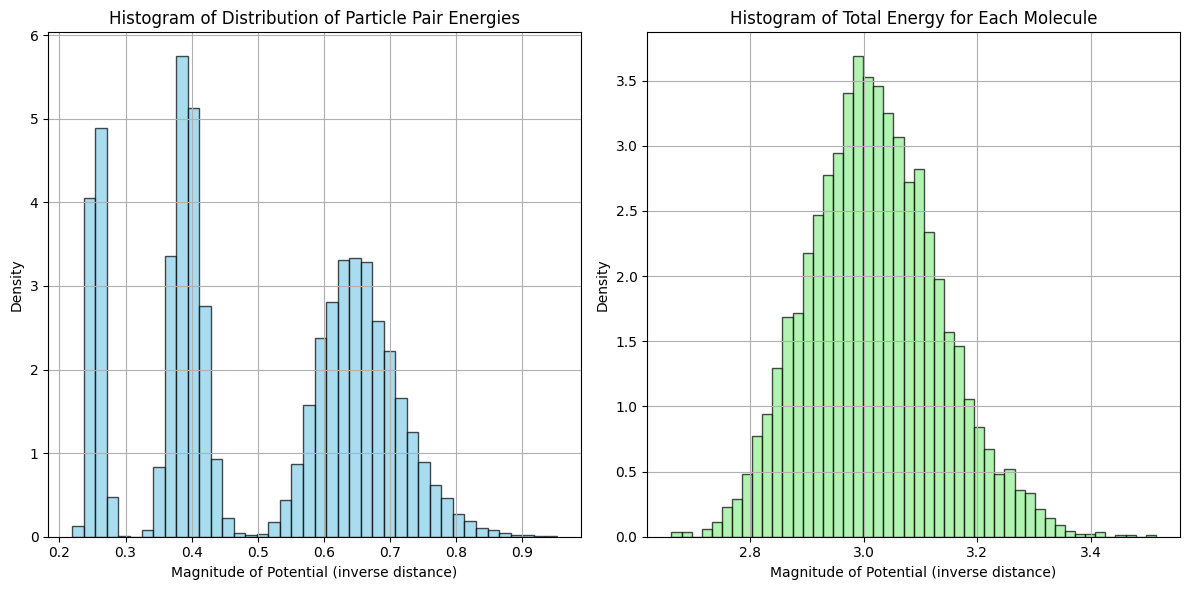

In [722]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

pairwise_energies = np.concatenate(potentials)

ax[0].hist(pairwise_energies, bins='auto', density=True, color='skyblue', edgecolor='black', alpha=0.7)
ax[0].set_title("Histogram of Distribution of Particle Pair Energies")
ax[0].set_xlabel("Magnitude of Potential (inverse distance)")
ax[0].set_ylabel("Density")
ax[0].grid(True)

ax[1].hist(total_energies, bins='auto', density=True, color='lightgreen', edgecolor='black', alpha=0.7)
ax[1].set_title("Histogram of Total Energy for Each Molecule")
ax[1].set_xlabel("Magnitude of Potential (inverse distance)")
ax[1].set_ylabel("Density")
ax[1].grid(True)

plt.tight_layout()
plt.show()



In [723]:
class Data(Dataset):
  """Dataset wrapper. Takes numpy arrays and stores them as torch tensors.
    Data is transformed to the device."""
  def __init__(self, x: np.ndarray,
                y: np.ndarray,
                device: str = DEVICE):
    self.x = torch.from_numpy(x).float().to(device)
    self.y =  torch.from_numpy(y).float().to(device)
    self.len = self.x.shape[0]
  
  def __getitem__(self, index: int) -> tuple:
    return self.x[index].float(), self.y[index].float()
  
  def __len__(self) -> int:
    return self.len

In [724]:
train_fraction = .8
n_train = int(train_fraction * n_samples)

ids = np.arange(n_samples)
np.random.shuffle(ids)
ids_train, ids_test  = map(np.array, np.split(ids, [n_train]))

flattened_coordinates = np.array(flattened_coordinates)
total_energies = np.array(total_energies)
distances = np.array(distances)

coords_train_data = Data(flattened_coordinates[ids_train], total_energies[ids_train])
coords_test_data = Data(flattened_coordinates[ids_test], total_energies[ids_test])
dists_train_data = Data(distances[ids_train], total_energies[ids_train])
dists_test_data = Data(distances[ids_test], total_energies[ids_test])

In [725]:
distances[ids_train].shape

(4000, 6)

In [726]:
batch_size = 128
coords_train_loader = DataLoader(coords_train_data, 
                         batch_size=batch_size, 
                         shuffle=True)
coord_test_loader = DataLoader(coords_test_data, 
                         batch_size=batch_size, 
                         shuffle=True)

dists_train_loader = DataLoader(dists_train_data, 
                         batch_size=batch_size, 
                         shuffle=True)
dists_test_loader = DataLoader(dists_test_data, 
                         batch_size=batch_size, 
                         shuffle=True)

In [727]:
# import torch
# import torch.nn as nn

# import torch.nn.functional as F
# from torch.utils.data import DataLoader, TensorDataset

class MLPPotentialEstimator(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size=1):
        super(MLPPotentialEstimator, self).__init__()
        
        layers = []
        in_size = input_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(in_size, hidden_size))
            layers.append(nn.ELU(alpha=1.0))  
            in_size = hidden_size
        
        layers.append(nn.Linear(in_size, output_size))
        
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs, device):
    """
    Function to train the model.

    Args:
        model: The model to train.
        train_loader: The DataLoader for the training data.
        criterion: The loss function (e.g., MSELoss).
        optimizer: The optimizer to update weights (e.g., Adam).
        num_epochs: The number of epochs to train.
    """
    train_losses = []
    test_losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        model.train()  

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()  
            
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            
            loss.backward()
            
            optimizer.step()
            
            running_loss += loss.item()
            total += labels.size(0)
        
        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
        train_losses.append(epoch_loss)
    
        model.eval() 
        with torch.no_grad(): 
            test_loss = 0.0
            for inputs, labels in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
            
            avg_test_loss = test_loss / len(test_loader)
            print(f"Test Loss: {avg_test_loss:.4f}")
            test_losses.append(test_loss)

        model.train() 

    return train_losses, test_losses


def evaluate_regression_model(model, dataloader, criterion, device=None, plot=False):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        model.to(device)
        model.eval() 

        total_loss = 0.0
        all_preds = []
        all_labels = []

        with torch.no_grad():  
            for batch in dataloader:
                inputs, labels = batch
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                total_loss += loss.item()

                all_preds.extend(outputs.cpu().detach().numpy().flatten())  # Flatten output
                all_labels.extend(labels.cpu().detach().numpy().flatten())  # Flatten labels

        if plot:
            plt.scatter(all_labels, all_preds, color='green', alpha=0.6, label='Test Data', s=1)
            plt.ylabel('Y-axis Label')
            plt.title('Scatter Plot Example')
            plt.show()

        # print(type(all_preds))
        # all_preds = np.array(all_preds)
        # all_labels = np.array(all_labels)

        # # Ensure correct data types
        # all_preds = all_preds.astype(np.float64)
        # all_labels = all_labels.astype(np.float64)

        # # Check for NaN or infinite values
        # if np.any(np.isnan(all_preds)) or np.any(np.isnan(all_labels)):
        #     print("NaN values found in predictions or labels.")
        # if np.any(np.isinf(all_preds)) or np.any(np.isinf(all_labels)):
        #     print("Infinite values found in predictions or labels.")

        #  # Debugging the shapes and types
        # print(f"Shape of all_preds: {all_preds.shape}")
        # print(f"Shape of all_labels: {all_labels.shape}")
        # print(f"Type of all_preds: {type(all_preds)}")
        # print(f"Type of all_labels: {type(all_labels)}")

        # Compute metrics
        avg_loss = total_loss / len(dataloader)
        mse = mean_squared_error(all_labels, all_preds)
        mae = mean_absolute_error(all_labels, all_preds)
        r2 = r2_score(all_labels, all_preds)

        return {
            "loss": avg_loss,
            "mse": mse,
            "mae": mae,
            "r2": r2,
        }
    
        

In [728]:
mean_squared_error(np.array([1, 2, 3]), np.array([4, 5, 6]))

9.0

In [729]:
coords_input_size = 8  #
dists_input_size = 6
hidden_sizes = [60, 60, 60, 60, 60, 60] 
output_size = 1  

coords_model = MLPPotentialEstimator(coords_input_size, hidden_sizes, output_size).to(DEVICE)
dists_model = MLPPotentialEstimator(dists_input_size, hidden_sizes, output_size).to(DEVICE)


criterion = nn.MSELoss()
dists_criterion = nn.MSELoss()
coords_optimizer = optim.Adam(coords_model.parameters(), lr=0.001)
dists_optimizer = optim.Adam(dists_model.parameters(), lr=.001)
scheduler = ReduceLROnPlateau(coords_optimizer, 'min', patience=5, factor=0.5, verbose=True)






/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [730]:
list(coords_model.parameters())

[Parameter containing:
 tensor([[ 0.0790,  0.3455,  0.1582, -0.1461,  0.1867, -0.1278,  0.2325,  0.2193],
         [-0.0080,  0.1657, -0.1401, -0.0738,  0.2509, -0.0316,  0.3088, -0.1448],
         [-0.2702, -0.0848, -0.1508, -0.2190,  0.1051, -0.2329,  0.0540,  0.3379],
         [ 0.1505,  0.2039, -0.2785, -0.1667, -0.1871,  0.3296,  0.3022, -0.2451],
         [-0.0239,  0.2951,  0.1793, -0.1627, -0.2178,  0.2186,  0.2432, -0.1698],
         [-0.3285, -0.0116,  0.0954,  0.1500,  0.2094, -0.1567,  0.1622,  0.3449],
         [ 0.1911, -0.0813, -0.0028, -0.1066,  0.1307, -0.0863,  0.0418, -0.3168],
         [ 0.1161,  0.0062, -0.0899, -0.0363, -0.1660, -0.2425,  0.1345,  0.3468],
         [ 0.1740,  0.3269, -0.2540, -0.0370, -0.0493,  0.3451, -0.2869,  0.1365],
         [-0.1571,  0.0376, -0.2567,  0.0237, -0.2378, -0.3139, -0.1234,  0.0147],
         [ 0.1232, -0.0113, -0.2301,  0.1418,  0.3005,  0.3271,  0.1867,  0.1041],
         [ 0.0099,  0.1285, -0.0138, -0.0254,  0.2966, -0.2209, 

In [731]:
num_epochs = 50
coords_train_losses, coords_test_losses = train_model(coords_model, coords_train_loader, coord_test_loader, criterion, coords_optimizer, num_epochs, DEVICE)

/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages/torc

Epoch [1/50], Loss: 2.6345
Test Loss: 0.2832
Epoch [2/50], Loss: 0.0613
Test Loss: 0.0138
Epoch [3/50], Loss: 0.0150
Test Loss: 0.0137
Epoch [4/50], Loss: 0.0142
Test Loss: 0.0139
Epoch [5/50], Loss: 0.0139
Test Loss: 0.0138
Epoch [6/50], Loss: 0.0140
Test Loss: 0.0137
Epoch [7/50], Loss: 0.0140
Test Loss: 0.0140
Epoch [8/50], Loss: 0.0139
Test Loss: 0.0138
Epoch [9/50], Loss: 0.0138
Test Loss: 0.0137
Epoch [10/50], Loss: 0.0140
Test Loss: 0.0138
Epoch [11/50], Loss: 0.0141
Test Loss: 0.0137
Epoch [12/50], Loss: 0.0138
Test Loss: 0.0137
Epoch [13/50], Loss: 0.0140
Test Loss: 0.0140
Epoch [14/50], Loss: 0.0139
Test Loss: 0.0136
Epoch [15/50], Loss: 0.0141
Test Loss: 0.0137
Epoch [16/50], Loss: 0.0138
Test Loss: 0.0138
Epoch [17/50], Loss: 0.0141
Test Loss: 0.0143
Epoch [18/50], Loss: 0.0139
Test Loss: 0.0138
Epoch [19/50], Loss: 0.0141
Test Loss: 0.0139
Epoch [20/50], Loss: 0.0140
Test Loss: 0.0136
Epoch [21/50], Loss: 0.0137
Test Loss: 0.0139
Epoch [22/50], Loss: 0.0139
Test Loss: 0.01

In [733]:
dists_num_epochs = 50
dists_train_losses, dists_test_losses = train_model(dists_model, dists_train_loader, dists_test_loader, dists_criterion, dists_optimizer, dists_num_epochs, DEVICE)


/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages/torc

Epoch [1/50], Loss: 2.0877
Test Loss: 0.2008
Epoch [2/50], Loss: 0.0495
Test Loss: 0.0169
Epoch [3/50], Loss: 0.0147
Test Loss: 0.0137
Epoch [4/50], Loss: 0.0137
Test Loss: 0.0136
Epoch [5/50], Loss: 0.0136
Test Loss: 0.0135
Epoch [6/50], Loss: 0.0138
Test Loss: 0.0136
Epoch [7/50], Loss: 0.0137
Test Loss: 0.0136
Epoch [8/50], Loss: 0.0137
Test Loss: 0.0135
Epoch [9/50], Loss: 0.0138
Test Loss: 0.0136
Epoch [10/50], Loss: 0.0138
Test Loss: 0.0136
Epoch [11/50], Loss: 0.0137
Test Loss: 0.0135
Epoch [12/50], Loss: 0.0138
Test Loss: 0.0138
Epoch [13/50], Loss: 0.0138
Test Loss: 0.0135
Epoch [14/50], Loss: 0.0137
Test Loss: 0.0135
Epoch [15/50], Loss: 0.0137
Test Loss: 0.0136
Epoch [16/50], Loss: 0.0137
Test Loss: 0.0135
Epoch [17/50], Loss: 0.0140
Test Loss: 0.0134
Epoch [18/50], Loss: 0.0139
Test Loss: 0.0138
Epoch [19/50], Loss: 0.0138
Test Loss: 0.0136
Epoch [20/50], Loss: 0.0137
Test Loss: 0.0136
Epoch [21/50], Loss: 0.0136
Test Loss: 0.0135
Epoch [22/50], Loss: 0.0137
Test Loss: 0.01

In [ ]:
# distances

In [ ]:
# dists_test_losses

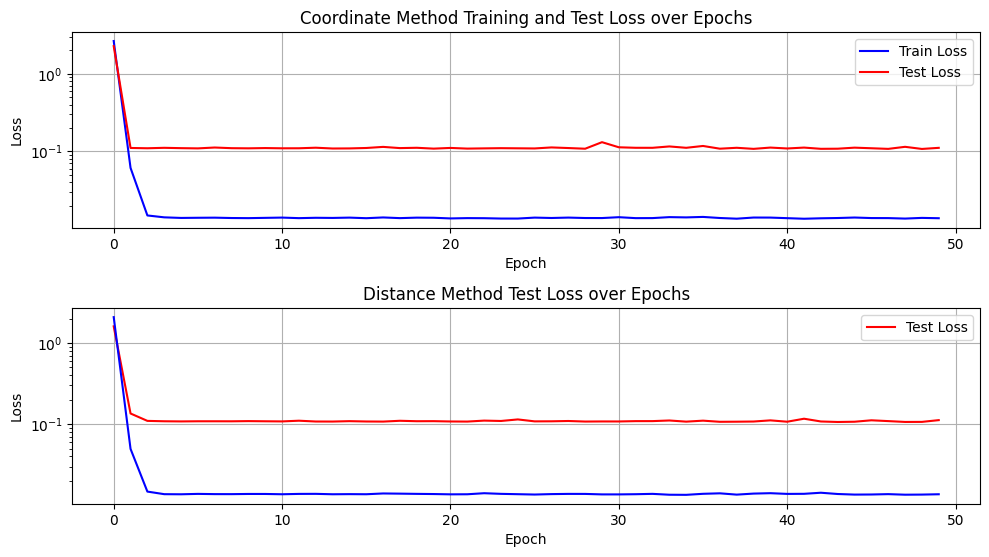

In [ ]:
plt.figure(figsize=(10, 8))

# First subplot (top)
plt.subplot(3, 1, 1)  
plt.plot(range(len(coords_train_losses)), coords_train_losses, label="Train Loss", color="blue")
plt.plot(range(len(coords_test_losses)), coords_test_losses, label="Test Loss", color="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Coordinate Method Training and Test Loss over Epochs")
plt.legend()
plt.yscale('log')
plt.grid(True)

plt.subplot(3, 1, 2)  # 2 rows, 1 column, second subplot
plt.plot(range(len(dists_test_losses)), dists_test_losses, label="Test Loss", color="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Distance Method Test Loss over Epochs")
plt.legend()
plt.yscale('log')
plt.grid(True)

# plt.subplot(3, 1, 3)  # 2 rows, 1 column, second subplot
plt.plot(range(len(dists_train_losses)), dists_train_losses, label="Train Loss", color="blue")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.title("Distance Method Training Loss over Epochs")
# plt.legend()
# plt.yscale('log')
# plt.grid(True)


plt.tight_layout()

plt.show()

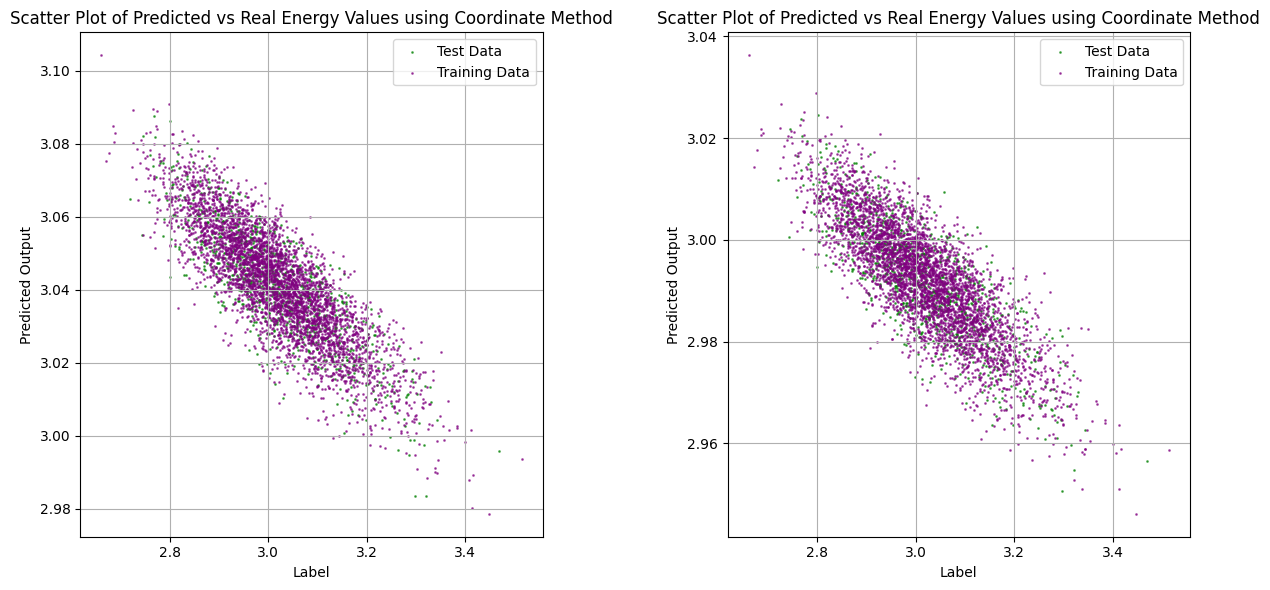

In [736]:
with torch.no_grad():
  coords_test_pred = []
  coords_test_real = []
  coords_train_pred = []
  coords_train_real = []

  dists_test_pred = []
  dists_test_real = []
  dists_train_pred = []
  dists_train_real = []

  for inputs, label in coords_test_data:
    output = coords_model(inputs)
    coords_test_pred.append(output) 
    coords_test_real.append(label)

  for inputs, label in coords_train_data:
    output = coords_model(inputs)
    coords_train_pred.append(output) 
    coords_train_real.append(label)
  
  for inputs, label in dists_test_data:
    output = dists_model(inputs)
    dists_test_pred.append(output) 
    dists_test_real.append(label)

  for inputs, label in dists_train_data:
    output = dists_model(inputs)
    dists_train_pred.append(output) 
    dists_train_real.append(label)
    
  # print(len(coords_input))
  # print(len(coords_test_pred))

  # len(coords_test_data)
  # coords_test_data[0]

  # test_coords = coords_test_data[:,0]
  # test_labels = coords_test_data[:,1]
  # train_coords = coords_train_data[:,0]
  # train_labels = coords_train_data[:,1] 

  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))  # 1 row, 2 columns
  ax1, ax2 = axes
  # plt.figure(figsize=(10, 6))

  # Scatter plot for predicted values
  ax1.scatter(coords_test_real, coords_test_pred, color='green', alpha=0.6, label='Test Data', s=1)
  ax1.scatter(coords_train_real, coords_train_pred, color='purple', alpha=0.6, label='Training Data', s=1)

  # Add labels and title
  ax1.set_xlabel('Label')
  ax1.set_ylabel('Predicted Output')
  ax1.set_title('Scatter Plot of Predicted vs Real Energy Values using Coordinate Method')

  ax2.scatter(dists_test_real, dists_test_pred, color='green', alpha=0.6, label='Test Data', s=1)
  ax2.scatter(dists_train_real, dists_train_pred, color='purple', alpha=0.6, label='Training Data', s=1)

  # Add labels and title
  ax2.set_xlabel('Label')
  ax2.set_ylabel('Predicted Output')
  ax2.set_title('Scatter Plot of Predicted vs Real Energy Values using Coordinate Method')


  ax1.legend()
  ax2.legend()

  plt.tight_layout()

  # Show grid for better readability
  ax1.grid()
  ax2.grid()
  fig.subplots_adjust(wspace=0.4, hspace=0.6)

  # Display the plot
  plt.show()

In [ ]:
evaluate_regression_model(coords_model, coord_test_loader, criterion)



{'loss': 0.012964908964931965,
 'mse': 0.013030074,
 'mae': 0.09068576,
 'r2': -0.01013039138804217}

In [ ]:
for inputs, label in dists_test_data:
  output = dists_model(inputs)
  print(output)
  dists_test_pred.append(output) 
  dists_test_real.append(label)

# for inputs, label in dists_train_data:
#   output = dists_model(inputs)
#   dists_train_pred.append(output) 
#   dists_train_real.append(label)

tensor([3.0060], grad_fn=<ViewBackward0>)
tensor([3.0141], grad_fn=<ViewBackward0>)
tensor([3.0075], grad_fn=<ViewBackward0>)
tensor([2.9969], grad_fn=<ViewBackward0>)
tensor([3.0350], grad_fn=<ViewBackward0>)
tensor([3.0105], grad_fn=<ViewBackward0>)
tensor([3.0131], grad_fn=<ViewBackward0>)
tensor([3.0182], grad_fn=<ViewBackward0>)
tensor([2.9888], grad_fn=<ViewBackward0>)
tensor([3.0062], grad_fn=<ViewBackward0>)
tensor([3.0258], grad_fn=<ViewBackward0>)
tensor([3.0051], grad_fn=<ViewBackward0>)
tensor([3.0281], grad_fn=<ViewBackward0>)
tensor([3.0163], grad_fn=<ViewBackward0>)
tensor([3.0264], grad_fn=<ViewBackward0>)
tensor([3.0100], grad_fn=<ViewBackward0>)
tensor([3.0267], grad_fn=<ViewBackward0>)
tensor([3.0401], grad_fn=<ViewBackward0>)
tensor([3.0138], grad_fn=<ViewBackward0>)
tensor([3.0215], grad_fn=<ViewBackward0>)
tensor([2.9957], grad_fn=<ViewBackward0>)
tensor([3.0160], grad_fn=<ViewBackward0>)
tensor([3.0135], grad_fn=<ViewBackward0>)
tensor([3.0080], grad_fn=<ViewBack

## 2 Data augmenatation

You can use this function to rotate the samples in your dataset.

In [ ]:
def rotate(vector, theta):
    """Rotates a two-dimensional vector by the angle theta."""
    rotMatrix = np.array(
        [[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]]
    )
    return np.matmul(rotMatrix, vector)

This is how you can permute data:

In [ ]:
ids = [1,2,3,0]
molecule_permuted = molecule[ids,:]

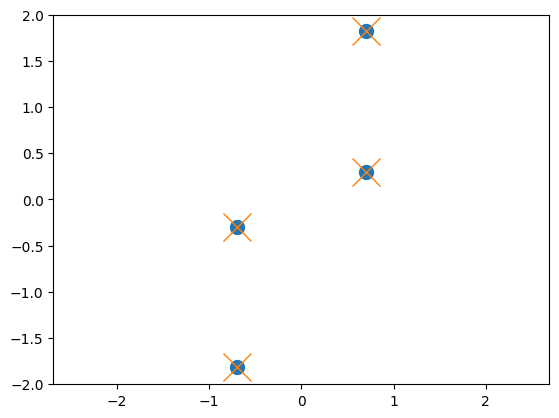

In [ ]:
plt.plot(molecule[:, 0], molecule[:, 1], "o", markersize=10)
plt.axis("equal")
plt.plot(molecule_permuted[:, 0], molecule_permuted[:, 1], "x", markersize=20)
plt.axis("equal")

plt.show()

/var/folders/y9/lzm82l3943n1ly680x98vpm40000gn/T/ipykernel_75846/1935090512.py:23: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


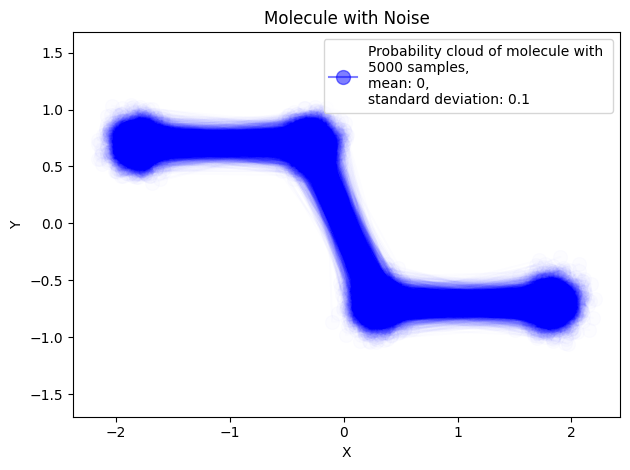

In [ ]:
rotated_noised_molecules = [np.transpose(rotate(np.transpose(molly), np.pi / 2)) for molly in noised_molecules]
plot_mollies(rotated_noised_molecules, "Rotated Molecule with Noise")

# noised_molecules[0]

In [ ]:
def permute_without_fixed_points(coords):
    n = len(coords)
    while True:
        perm = torch.randperm(n)  # Generate random permutation of indices
        if not torch.all(perm == torch.arange(n)):  # Check for no fixed points
            return coords[perm]  # Apply permutation to the tensor

In [ ]:
rotated_flattened_coordinates = [np.reshape(mol, (n_atoms*n_dimensions)) for mol in rotated_noised_molecules]
rotated_distances = [pdist(mol) for mol in noised_molecules]
rotated_potentials = [(1 / dist) for dist in rotated_distances]
rotated_total_energies = [sum(potential) for potential in rotated_potentials]

permutated_rotated_noised_molecules = [permute_without_fixed_points(molly) for molly in rotated_noised_molecules]
permutated_rotated_flattened_coordinates = [np.reshape(mol, (n_atoms*n_dimensions)) for mol in permutated_rotated_noised_molecules]
permutated_rotated_distances = [permute_without_fixed_points(molly) for molly in rotated_distances]

rotated_coords_data = Data(flattened_coordinates, total_energies)
rotated_dists_data = Data(distances, total_energies)
permutated_rotated_coords_data = Data(np.array(permutated_rotated_flattened_coordinates), total_energies)
permutated_rotated_dists_data = Data(np.array(permutated_rotated_distances), total_energies)

batch_size = 128
rotated_coords_loader = DataLoader(rotated_coords_data, 
                         batch_size=batch_size, 
                         shuffle=True)

rotated_dists_loader = DataLoader(rotated_dists_data, 
                         batch_size=batch_size, 
                         shuffle=True)

permutated_rotated_coords_loader = DataLoader(permutated_rotated_coords_data, 
                         batch_size=batch_size, 
                         shuffle=True)

permutated_rotated_dists_loader = DataLoader(permutated_rotated_dists_data, 
                         batch_size=batch_size, 
                         shuffle=True)

print("Rotated coords model: ", evaluate_regression_model(coords_model, rotated_coords_loader, criterion))
print("Rotated distances model: ", evaluate_regression_model(dists_model, rotated_dists_loader, criterion))

print("Permutated rotated coords model: ", evaluate_regression_model(coords_model, permutated_rotated_coords_loader, criterion))
print("Permutated rotated distances model: ", evaluate_regression_model(dists_model, permutated_rotated_dists_loader, criterion))


/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages/torch/

Rotated coords model:  {'loss': 0.013428333774209022, 'mse': 0.013443945, 'mae': 0.091947034, 'r2': -0.01000830335778713}
Rotated distances model:  {'loss': 0.013320633827243, 'mse': 0.016187744, 'mae': 0.10108751, 'r2': -0.21614271920843198}
Permutated rotated coords model:  {'loss': 0.41283213649876416, 'mse': 0.4065954, 'mae': 0.2177741, 'r2': -29.54644322543509}
Permutated rotated distances model:  {'loss': 0.016963166021741926, 'mse': 0.019945394, 'mae': 0.11116389, 'r2': -0.4984449519745313}


/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages/torch/

In [ ]:
# permutated_rotated_noised_molecules

/var/folders/y9/lzm82l3943n1ly680x98vpm40000gn/T/ipykernel_75846/1935090512.py:23: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


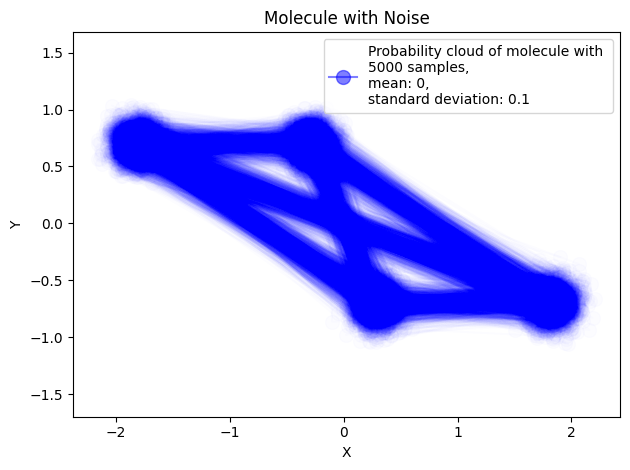

In [ ]:

plot_mollies(permutated_rotated_noised_molecules, "Permutated and Rotated Molecules with Noise")
# permutated_rotated_noised_molecules

In [ ]:
# 2.3

augmented_coords1 = np.vstack((rotated_flattened_coordinates, flattened_coordinates))
permutated_coords_without_rotating = [np.reshape(permute_without_fixed_points(molly), (n_atoms*n_dimensions)) for molly in noised_molecules]
augmented_coords2 = np.vstack((flattened_coordinates, permutated_coords_without_rotating))

# print(augmented_coords1)
# print(augmented_coords2)

def get_dists_from_flattened(mol):
  x1, y1, x2, y2, x3, y3, x4, y4 = mol
  d12 = ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** .5
  d13 = ((x1 - x3) ** 2 + (y1 - y3) ** 2) ** .5
  d14 = ((x1 - x4) ** 2 + (y1 - y4) ** 2) ** .5
  d23 = ((x2 - x3) ** 2 + (y2 - y3) ** 2) ** .5
  d24 = ((x2 - x4) ** 2 + (y2 - y4) ** 2) ** .5
  d34 = ((x3 - x4) ** 2 + (y3 - y4) ** 2) ** .5
  rtn = [d12, d13, d14, d23, d24, d34]
  return rtn


augmented_distances1 = [get_dists_from_flattened(mol) for mol in augmented_coords1]
augmented_potentials1 = [(1 / dist) for dist in augmented_coords1]
augmented_total_energies1 = np.array([sum(potential) for potential in augmented_potentials1])

augmented_distances2 = np.array([get_dists_from_flattened(mol) for mol in augmented_coords2])
augmented_potentials2 = [(1 / dist) for dist in augmented_coords2]
augmented_total_energies2 = np.array([sum(potential) for potential in augmented_potentials2])

train_fraction = .8
n_train = int(train_fraction * n_samples * 2)

ids = np.arange(n_samples * 2)
print(ids)
np.random.shuffle(ids)
ids_train, ids_test  = map(np.array, np.split(ids, [n_train]))
ids_train = np.array(ids_train)
ids_test = np.array(ids_test)

print(ids_train)
print(ids_test)

aug1_train_data = Data(augmented_coords1[ids_train], augmented_total_energies1[ids_train])
aug1_test_data = Data(augmented_coords1[ids_test], augmented_total_energies1[ids_test])
aug2_train_data = Data(augmented_coords2[ids_train], augmented_total_energies2[ids_train])
aug2_test_data = Data(augmented_coords2[ids_test], augmented_total_energies2[ids_test])

batch_size = 128
aug1_train_loader = DataLoader(aug1_train_data, 
                         batch_size=batch_size, 
                         shuffle=True)
aug1_test_loader = DataLoader(aug1_test_data, 
                         batch_size=batch_size, 
                         shuffle=True)

aug2_train_loader = DataLoader(aug2_train_data, 
                         batch_size=batch_size, 
                         shuffle=True)
aug2_test_loader = DataLoader(aug2_test_data, 
                         batch_size=batch_size, 
                         shuffle=True)

# coords_input_size = 8  # Example input size (number of features)
# dists_input_size = 6
# hidden_sizes = [128, 128, 128, 128, 128, 64, 64, 32]  # Number of neurons per hidden layer
# output_size = 1  # Single output (potential energy)

augmented_model1 = MLPPotentialEstimator(coords_input_size, hidden_sizes, output_size)
augmented_model2 = MLPPotentialEstimator(coords_input_size, hidden_sizes, output_size)


criterion = nn.MSELoss()
dists_criterion = nn.MSELoss()
augmented_optimizer1 = optim.SGD(augmented_model1.parameters(), lr=0.001)
augmented_optimizer2 = optim.SGD(augmented_model2.parameters(), lr=.001)
# scheduler = ReduceLROnPlateau(coords_optimizer, 'min', patience=5, factor=0.5, verbose=True)

# original_and_rotated_coords


[   0    1    2 ... 9997 9998 9999]
[ 200  279 6609 ... 6706 2074 1371]
[1886 3887 8226 ... 3116 2374 4993]


In [ ]:
num_epochs = 50
augmented_coords_train_losses, coords_test_losses = train_model(augmented_model1, aug1_train_loader, aug1_test_loader, criterion, augmented_optimizer1, num_epochs)

/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages/torc

Epoch [1/50], Loss: 199.1544
Test Loss: 299.6363
Epoch [2/50], Loss: 198.9436
Test Loss: 302.9749
Epoch [3/50], Loss: 199.8207
Test Loss: 300.2762
Epoch [4/50], Loss: 199.1355
Test Loss: 299.1169
Epoch [5/50], Loss: 198.8954
Test Loss: 299.7159
Epoch [6/50], Loss: 200.2759
Test Loss: 299.1864
Epoch [7/50], Loss: 199.3014
Test Loss: 299.4184
Epoch [8/50], Loss: 199.2579
Test Loss: 299.3448
Epoch [9/50], Loss: 199.5267
Test Loss: 299.7146
Epoch [10/50], Loss: 199.0162
Test Loss: 324.9948
Epoch [11/50], Loss: 198.9164
Test Loss: 299.3464
Epoch [12/50], Loss: 198.9105
Test Loss: 299.4441
Epoch [13/50], Loss: 200.0258
Test Loss: 299.7627
Epoch [14/50], Loss: 199.0885
Test Loss: 324.4987
Epoch [15/50], Loss: 198.9526
Test Loss: 300.0192
Epoch [16/50], Loss: 200.5235
Test Loss: 299.2676
Epoch [17/50], Loss: 198.9878
Test Loss: 299.4845
Epoch [18/50], Loss: 199.6572
Test Loss: 299.2425
Epoch [19/50], Loss: 198.9397
Test Loss: 300.4981
Epoch [20/50], Loss: 199.2152
Test Loss: 324.6218
Epoch [21

In [ ]:
num_epochs = 50
aug1_train_losses, aug2_test_losses = train_model(augmented_model2, aug2_train_loader, aug2_test_loader, criterion, augmented_optimizer2, num_epochs)

Epoch [1/50], Loss: 198.9786
Test Loss: 299.8580
Epoch [2/50], Loss: 198.8740
Test Loss: 299.2013
Epoch [3/50], Loss: 198.9105
Test Loss: 299.3807
Epoch [4/50], Loss: 198.8996
Test Loss: 324.3775
Epoch [5/50], Loss: 199.6197
Test Loss: 299.2983
Epoch [6/50], Loss: 199.0604
Test Loss: 299.1960
Epoch [7/50], Loss: 199.2490
Test Loss: 304.0074
Epoch [8/50], Loss: 198.8571
Test Loss: 299.7973
Epoch [9/50], Loss: 209.9443
Test Loss: 303.3257
Epoch [10/50], Loss: 198.8827
Test Loss: 324.2032
Epoch [11/50], Loss: 199.0379
Test Loss: 299.3837
Epoch [12/50], Loss: 198.9846
Test Loss: 299.2365
Epoch [13/50], Loss: 199.0252
Test Loss: 304.6783
Epoch [14/50], Loss: 200.7433
Test Loss: 329.6003
Epoch [15/50], Loss: 199.1033
Test Loss: 299.2701
Epoch [16/50], Loss: 198.8869
Test Loss: 299.2079
Epoch [17/50], Loss: 198.9102
Test Loss: 299.4222
Epoch [18/50], Loss: 199.1144
Test Loss: 299.3832
Epoch [19/50], Loss: 198.8573
Test Loss: 299.2359
Epoch [20/50], Loss: 198.8503
Test Loss: 303.4926
Epoch [21

In [ ]:
print(evaluate_regression_model(augmented_model1, aug1_test_loader, criterion))
print(evaluate_regression_model(augmented_model2, aug2_test_loader, criterion))

{'loss': 299.4300103485584, 'mse': 306.32596, 'mae': 2.7998457, 'r2': -0.0018023055668008325}
{'loss': 299.28931722044945, 'mse': 306.21088, 'mae': 2.836371, 'r2': -1.610083454561817e-06}


/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([80])) that is different to the input size (torch.Size([80, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
